## Edge Detection
Detect Signals in OAAM Functions Layer. Outputs polylines describing the connections. 

Conceptionally similar to scalable vertex detection. 

Tailored on the functions editor. Should be generalizable with medium effort. Expects vertical or horizontal line segments. Does not yet support crossings or other crossing solutions. Not tested for lines close to each other. Does not support diagonal lines, currently not a thing. Would be interesting with probabilistic Hough Trafo, but would probably need to subtract all other matches from the result. 

Maybe switch to template matching (with kind of same kernel/template). 

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import random as random

### Input

In [2]:
# Define the paths
# target_image_path = 'screenshot-3-tasks.PNG'
# target_image_path = 'door_system.png'
# target_image_path = 'door_system_after_preprocessing_big_padding.png' # version 2 for paper with scaled vertex
# target_image_path = 'door_system_after_preprocessing_big.png' # for other images
# target_image_path = 'system.png'
# target_image_path = 'crossing.png'
# target_image_path = 'images/multiplecrossings.png'
# target_image_path = 'images/deviceeditor.png'
target_image_path = 'images/allocations_2.png'

target_img = cv2.imread(target_image_path)

# Convert to grayscale
target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

activate_plotly = False

### Visualization of Input
Grayscale is enough here. Kernel methods are not really for multi channel images.

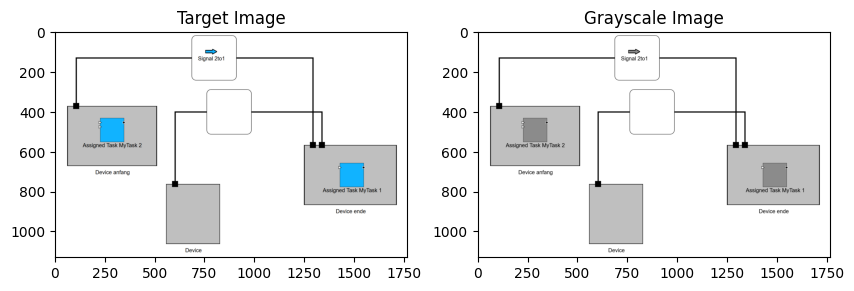

In [3]:
# Draw target image and grayscale image side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Draw target image
ax[0].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Target Image')

# Draw grayscale image
ax[1].imshow(target_gray, cmap='gray')
ax[1].set_title('Grayscale Image')

plt.show()

## Kernel / Custom Filter
Kernel Custom Line Detection and generation of intersection template image for later use

idea for later: search for many thicknesses of lines

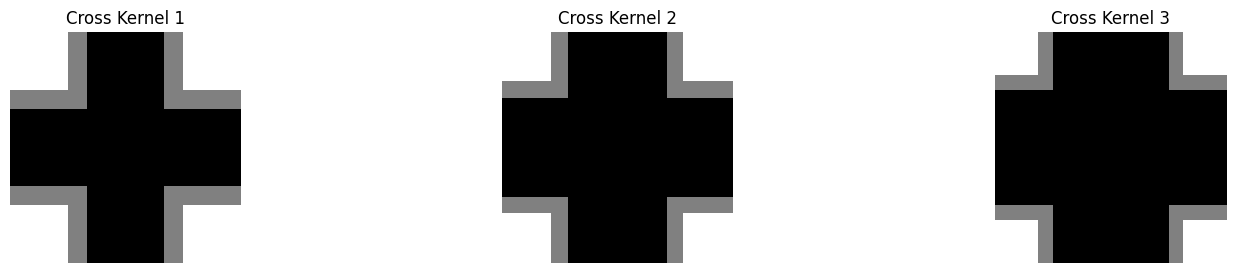

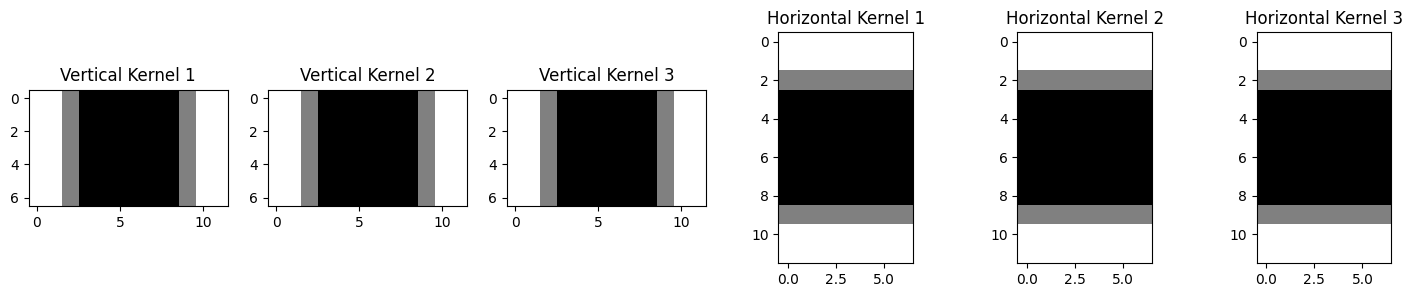

In [4]:
# Define custom kernels
kernels_vertical = [
    np.tile(np.array([[1, 1, 0, -1, -1, -1, -1, -1, -1, 0, 1, 1]], dtype=np.float32), (7, 1)),
    np.tile(np.array([[1, 1, 0, -1, -1, -1, -1, -1, -1, 0, 1, 1]], dtype=np.float32), (7, 1)),
    np.tile(np.array([[1, 1, 0, -1, -1, -1, -1, -1, -1, 0, 1, 1]], dtype=np.float32), (7, 1))
]

kernels_horizontal = [np.transpose(k) for k in kernels_vertical]



# First cross kernel
kernel_cross_0= np.ones((12, 12))
kernel_cross_0[3:9, 0:12] = 0.5  # Left vertical outline
kernel_cross_0[0:12, 3:9] = 0.5  # Right vertical outline
kernel_cross_0[4:8, 0:12] = 0  # Vertical part of the cross
kernel_cross_0[0:12, 4:8] = 0  # Horizontal part of the cross

# Second cross kernel (2 pixels thicker)
kernel_cross_1 = np.ones((14, 14))
kernel_cross_1[3:11, 0:14] = 0.5  # Left vertical outline
kernel_cross_1[0:14, 3:11] = 0.5  # Right vertical outline
kernel_cross_1[4:10, 0:14] = 0  # Vertical part of the cross
kernel_cross_1[0:14, 4:10] = 0  # Horizontal part of the cross

# Third cross kernel (4 pixels thicker)
kernel_cross_2 = np.ones((16, 16))
kernel_cross_2[3:13, 0:16] = 0.5  # Left vertical outline
kernel_cross_2[0:16, 3:13] = 0.5  # Right vertical outline
kernel_cross_2[4:12, 0:16] = 0  # Vertical part of the cross
kernel_cross_2[0:16, 4:12] = 0  # Horizontal part of the cross

# Visualize the cross kernels
fig, axes = plt.subplots(1, 3, figsize=(18, 3))

# Plot first cross kernel
axes[0].imshow(kernel_cross_0, cmap='gray')
axes[0].set_title('Cross Kernel 1')

# Plot second cross kernel
axes[1].imshow(kernel_cross_1, cmap='gray')
axes[1].set_title('Cross Kernel 2')

# Plot third cross kernel
axes[2].imshow(kernel_cross_2, cmap='gray')
axes[2].set_title('Cross Kernel 3')

# Remove axis ticks
for ax in axes:
    ax.axis('off')

plt.show()

# Visualize the kernels
fig, axes = plt.subplots(1, 6, figsize=(18, 3))

# Plot vertical kernels
axes[0].imshow(kernels_vertical[0], cmap='gray')
axes[0].set_title('Vertical Kernel 1')
axes[1].imshow(kernels_vertical[1], cmap='gray')
axes[1].set_title('Vertical Kernel 2')
axes[2].imshow(kernels_vertical[2], cmap='gray')
axes[2].set_title('Vertical Kernel 3')

# Plot horizontal kernels
axes[3].imshow(kernels_horizontal[0], cmap='gray')
axes[3].set_title('Horizontal Kernel 1')
axes[4].imshow(kernels_horizontal[1], cmap='gray')
axes[4].set_title('Horizontal Kernel 2')
axes[5].imshow(kernels_horizontal[2], cmap='gray')
axes[5].set_title('Horizontal Kernel 3')

plt.show()

# Save the cross kernel as a 10 by 10 pixel .png
# kernel_cross_resized = cv2.resize(kernel_cross_0, (12, 12), interpolation=cv2.INTER_NEAREST)
# cv2.imwrite('cross_kernel_0.png', (kernel_cross_0 * 255).astype(np.uint8))
# kernel_cross_resized = cv2.resize(kernel_cross_1, (14, 14), interpolation=cv2.INTER_NEAREST)
# cv2.imwrite('cross_kernel_1.png', (kernel_cross_1 * 255).astype(np.uint8))
# kernel_cross_resized = cv2.resize(kernel_cross_2, (16, 16), interpolation=cv2.INTER_NEAREST)
# cv2.imwrite('cross_kernel_2.png', (kernel_cross_2 * 255).astype(np.uint8))

# Draw the kernel
# fig, ax = plt.subplots(1, 2, figsize=(7, 3))
# ax[0].imshow(kernel_horizontal, cmap='gray')
# ax[0].set_title('Horizontal Kernel')
# ax[1].imshow(kernel_cross, cmap='gray')
# ax[1].set_title('Cross Kernel')
# plt.show()
# Save the cross kernel as a 10 by 10 pixel .png
# kernel_cross_resized = cv2.resize(kernel_cross, (10, 10), interpolation=cv2.INTER_NEAREST)
# cv2.imwrite('cross_kernel.png', (kernel_cross * 255).astype(np.uint8))

#### Applying custom filter to find vertical and horizontal edges
tried to find intersections this way as well, but it did not work

visualization of output at the end

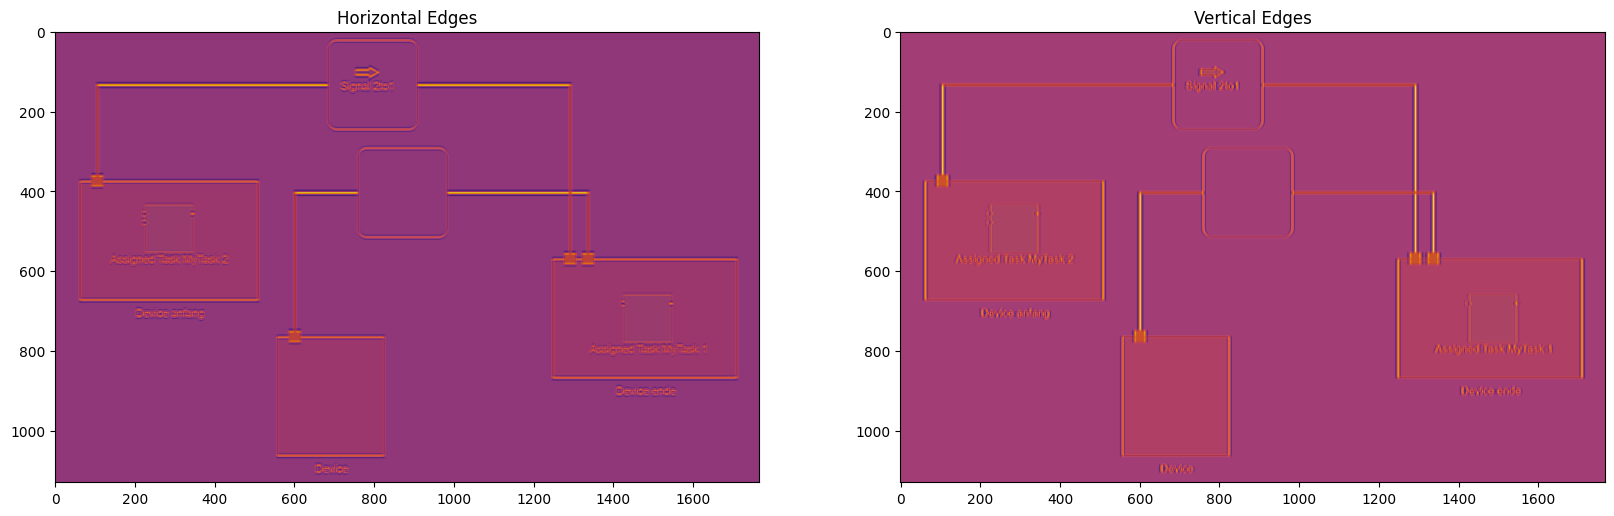

In [5]:
target_gray_temp = target_gray.copy()

result_filter_ver = []
for kernel in kernels_vertical:
    result = cv2.filter2D(target_gray_temp, cv2.CV_32F, kernel)
    result_filter_ver.append(result)
result_filter_hor = []
for kernel in kernels_horizontal:
    result = cv2.filter2D(target_gray_temp, cv2.CV_32F, kernel)
    result_filter_hor.append(result)
    
combined = np.zeros_like(result_filter_ver[0])
for result in result_filter_ver:
    combined = np.maximum(combined, result)
for result in result_filter_hor:
    combined = np.maximum(combined, result)

# Combine the individual results into single arrays
combined_hor = np.maximum.reduce(result_filter_hor)
combined_ver = np.maximum.reduce(result_filter_ver)

result_filter_hor = combined_hor
result_filter_ver = combined_ver

# Overlay both heatmaps on the target image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[0].imshow(combined_hor, cmap='inferno', alpha=0.9)
ax[0].set_title('Horizontal Edges')
ax[1].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[1].imshow(combined_ver, cmap='inferno', alpha=0.9)
ax[1].set_title('Vertical Edges')
plt.show()

#### Histogram

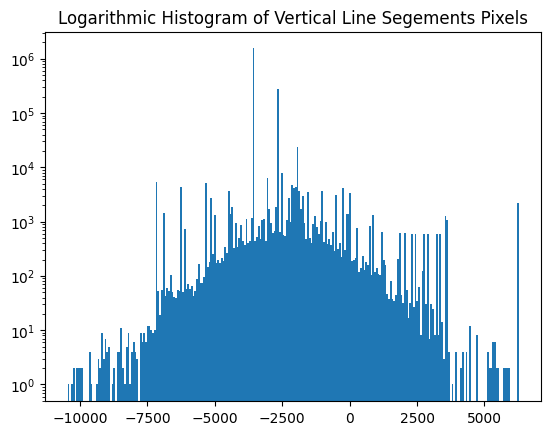

In [6]:
# Draw a logarithmic histogram of vertical edges
plt.hist(result_filter_ver.ravel(), bins=256, log=True)
plt.title('Logarithmic Histogram of Vertical Line Segements Pixels')
plt.show()

#### Visualization of Custom Filter 3D with plotly

In [7]:
if activate_plotly:
    # Create a 3D surface plot of the vertical edges
    fig = go.Figure(data=[go.Surface(z=result_filter_ver)])
    # fig = go.Figure(data=[go.Surface(z=result_filter_hor)])  # Horizontal edges
    fig.update_layout(
        title='3D Surface Plot of Vertical Edges',
        height=1500,
        scene=dict(
            yaxis = dict(autorange='reversed'),
            )
        )
    fig.show()

#### Visualization of Custom Filter 3D with plotly with screenshot for paper

In [8]:
template_matching_result = result_filter_hor.copy()
target_gray_tmp = target_gray.copy()

# target image
activate_plotly = False
if activate_plotly:
  fig = go.Figure()

  # Layer 1: 3D Plot of Heatmap
  fig.add_trace(go.Surface(
    z = template_matching_result,
    showscale = False
  ))

  # Layer 2: 2D Plot of Target Image at 1000
  z_image = np.ones_like(target_gray_tmp) * 1000
  fig.add_trace(go.Surface(
    z = z_image,
    showscale = False,
    # opacity = 0.5,
    surfacecolor = target_gray_tmp,
    colorscale = 'gray',
  ))

  fig.update_layout(title='Heatmap Custom Filter Vertical Edges', 
                    scene=dict(
                    yaxis=dict(autorange='reversed') 
                    ),
                    height=1500,
                    scene_aspectratio=dict(x=2, y=1, z=0.2),
                    )

  fig.show()

#### Normalizing to 8 Bit

In [9]:
# Normalize to 0-255 and convert to uint8
result_filter_ver_norm = cv2.normalize(result_filter_ver, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
result_filter_hor_norm = cv2.normalize(result_filter_hor, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

#### Check Histogram
histogram looks like above, but with other scale -> what we want

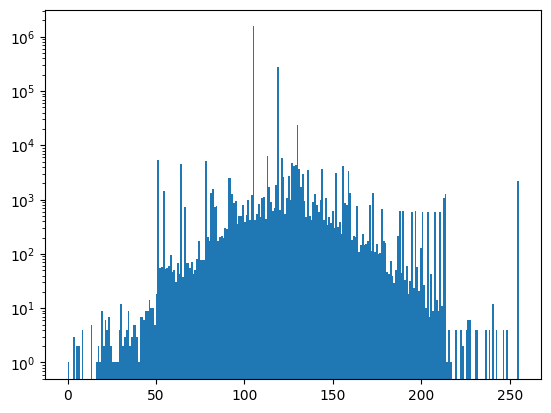

In [10]:
# plot the histogram of the normalized vertical edges, log scale
plt.hist(result_filter_ver_norm.ravel(), 256, log=True)
plt.show()

#### Thresholding and visualization

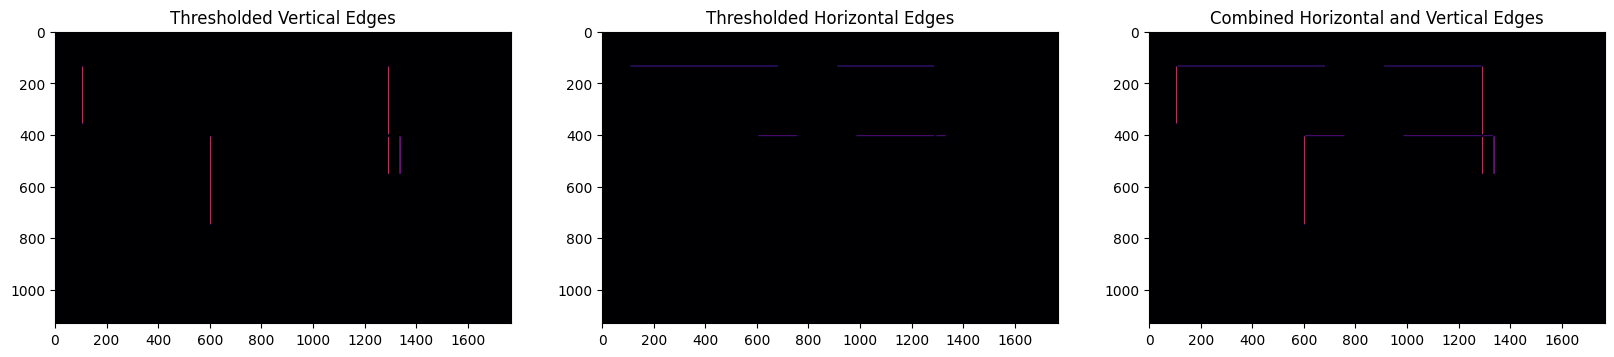

In [11]:
threshold = 230
_, result_filter_ver_thresh = cv2.threshold(result_filter_ver_norm, threshold, 255, cv2.THRESH_BINARY)
_, result_filter_hor_thresh = cv2.threshold(result_filter_hor_norm, threshold, 255, cv2.THRESH_BINARY)

hv_edges_thresh = result_filter_ver_thresh + result_filter_hor_thresh
# Draw the thresholded images and histogram next to each other
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

# Thresholded Vertical Edges
ax[0].imshow(result_filter_ver_thresh, cmap='inferno')
ax[0].set_title('Thresholded Vertical Edges')

# Thresholded Horizontal Edges
ax[1].imshow(result_filter_hor_thresh, cmap='inferno')
ax[1].set_title('Thresholded Horizontal Edges')

# Combined Horizontal and Vertical Edges
ax[2].imshow(hv_edges_thresh, cmap='inferno')
ax[2].set_title('Combined Horizontal and Vertical Edges')

# Logarithmic Histogram of Thresholded Vertical Edges
# ax[1, 1].hist(result_filter_ver_thresh.ravel(), bins=256, log=True)
# ax[1, 1].set_title('Logarithmic Histogram of Thresholded Vertical Edges')

plt.show()


### From Pixels to Contours
Group Pixels to Contours and draw them onto the target image

Found 5 horizontal contours, and 5 vertical contours


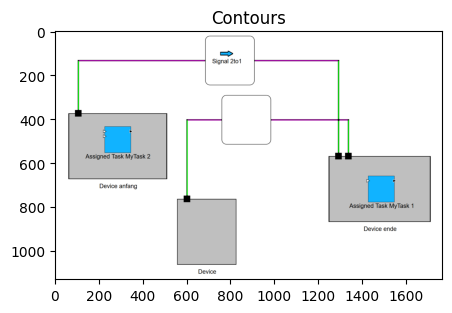

In [12]:
# Find contours
contours_hor, _ = cv2.findContours(result_filter_hor_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_ver, _ = cv2.findContours(result_filter_ver_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f'Found {len(contours_hor)} horizontal contours, and {len(contours_ver)} vertical contours')

# Draw the contours. Horizontal in blue, vertical in green
contour_img_all = target_img.copy()
# Convert contours to the correct format
contours_hor = [np.array(contour, dtype=np.int32) for contour in contours_hor]
contours_ver = [np.array(contour, dtype=np.int32) for contour in contours_ver]

# Draw contours
cv2.drawContours(contour_img_all, contours_hor, -1, (255, 0, 255), 2)
cv2.drawContours(contour_img_all, contours_ver, -1, (0, 255, 0), 2)

# Plot the contours
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(cv2.cvtColor(contour_img_all, cv2.COLOR_BGR2RGB))
ax.set_title('Contours')
plt.show()

#### Filter out very short Contours
thes are mainly false positives, for example at the ports or the characters.
They are very hard to see.

In [13]:
# Filter out very short contours
min_contour_length = 20
contours_hor_filtered = [c for c in contours_hor if cv2.arcLength(c, False) > min_contour_length]
contours_ver_filtered = [c for c in contours_ver if cv2.arcLength(c, False) > min_contour_length]
print(f'After filtering, found {len(contours_hor_filtered)} horizontal contours, and {len(contours_ver_filtered)} vertical contours.')
print(f'Filtered out {len(contours_hor) - len(contours_hor_filtered)} horizontal contours, and {len(contours_ver) - len(contours_ver_filtered)} vertical contours.')

# Print the points of the filtered contours
# for i, contour in enumerate(contours_hor_filtered):
#     print(f"Horizontal contour {i}: {contour.squeeze().tolist()}")
# for i, contour in enumerate(contours_ver_filtered):
#     print(f"Vertical contour {i}: {contour.squeeze().tolist()}")

After filtering, found 5 horizontal contours, and 5 vertical contours.
Filtered out 0 horizontal contours, and 0 vertical contours.


#### From Contours to Line Segments
Contours are areas (but very line segment looking). So they are approximated to line segments.

In [14]:
def vertical_contours_to_vertical_segments(contours):
    lines = []
    for contour in contours:
        # Simplify contour to ensure it's processed as a line if it's not already
        simplified_contour = cv2.approxPolyDP(contour, epsilon=0.5, closed=False)

        # Extract the vertical extents by finding min and max y coordinates
        x_coords = simplified_contour[:, :, 0]
        y_coords = simplified_contour[:, :, 1]
        
        y1, y2 = np.min(y_coords), np.max(y_coords)
        x = np.mean(x_coords).astype(int)  # Assuming vertical, x should be constant
        
        lines.append(((x, y1), (x, y2)))
    
    return lines

def horizontal_contours_to_horizontal_segments(contours):
    lines = []
    for contour in contours:
        # Simplify contour to ensure it's processed as a line if it's not already
        simplified_contour = cv2.approxPolyDP(contour, epsilon=0.5, closed=False)

        # Extract the horizontal extents by finding min and max x coordinates
        x_coords = simplified_contour[:, :, 0]
        y_coords = simplified_contour[:, :, 1]
        
        x1, x2 = np.min(x_coords), np.max(x_coords)
        y = np.mean(y_coords).astype(int)  # Assuming horizontal, y should be constant
        
        lines.append(((x1, y), (x2, y)))
    
    return lines

line_segments_ver = vertical_contours_to_vertical_segments(contours_ver_filtered)
line_segments_hor = horizontal_contours_to_horizontal_segments(contours_hor_filtered)

#### Visualize the Line Segments and highlight the points

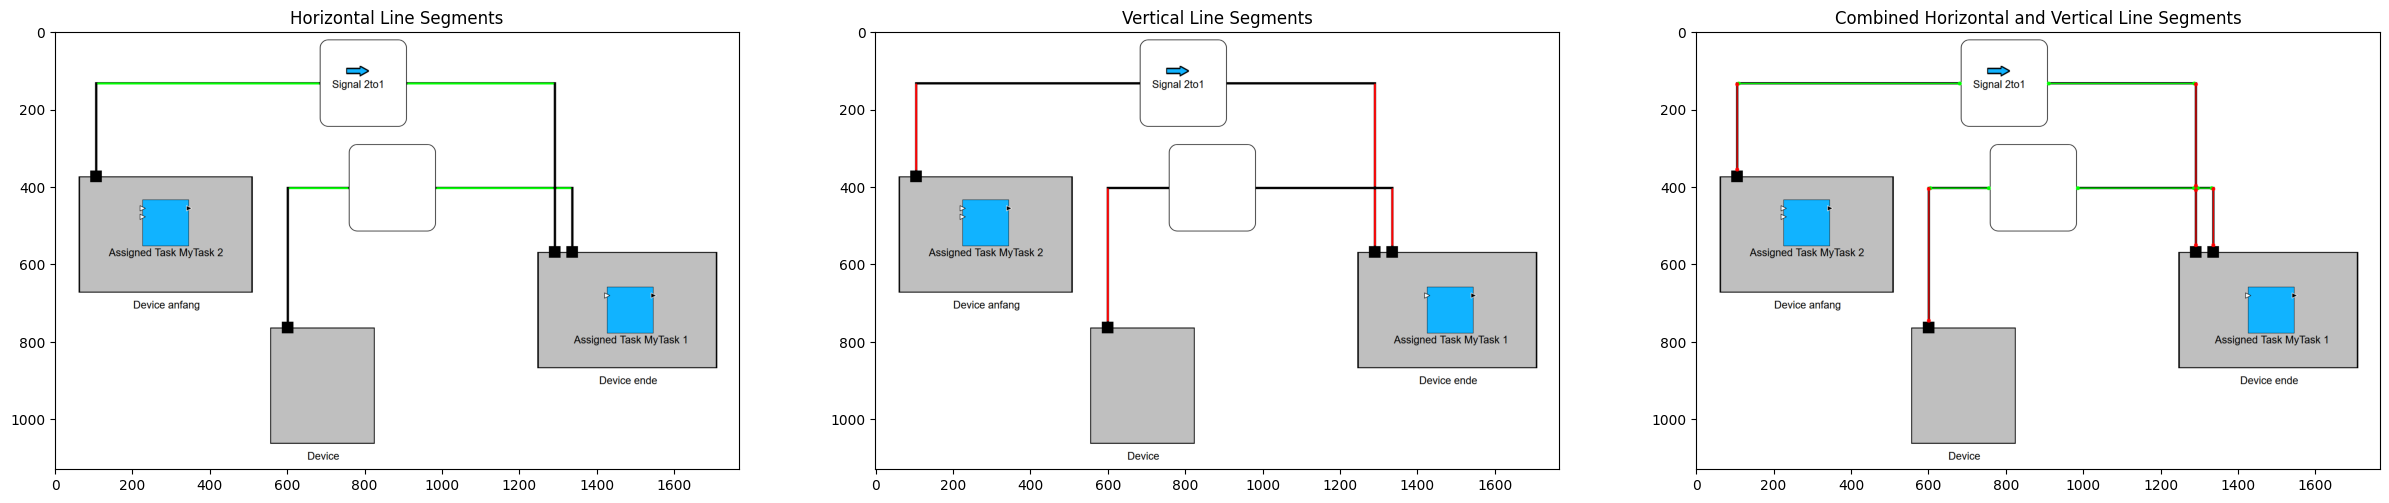

Vertical line segment 0: Start: (1291, 410), End: (1291, 552)
Vertical line segment 1: Start: (1336, 407), End: (1336, 552)
Vertical line segment 2: Start: (601, 407), End: (601, 747)
Vertical line segment 3: Start: (1291, 137), End: (1291, 399)
Vertical line segment 4: Start: (106, 137), End: (106, 357)

Horizontal line segment 0: Start: (1296, 405), End: (1332, 405)
Horizontal line segment 1: Start: (986, 405), End: (1286, 405)
Horizontal line segment 2: Start: (605, 405), End: (756, 405)
Horizontal line segment 3: Start: (911, 135), End: (1287, 135)
Horizontal line segment 4: Start: (110, 135), End: (681, 135)


In [15]:
# Draw the horizontal lines
edges_hor_img = target_img.copy()
for line in line_segments_hor:
    cv2.line(edges_hor_img, line[0], line[1], (0, 255, 0), 4)

# Draw the vertical lines
edges_ver_img = target_img.copy()
for line in line_segments_ver:
    cv2.line(edges_ver_img, line[0], line[1], (0, 0, 255), 4)

# Draw the combined lines
edges_combined_img = target_img.copy()
for line in line_segments_hor:
    cv2.line(edges_combined_img, line[0], line[1], (0, 255, 0), 2)
    cv2.circle(edges_combined_img, line[0], 5, (0, 255, 0), -1)
    cv2.circle(edges_combined_img, line[1], 5, (0, 255, 0), -1)
for line in line_segments_ver:
    cv2.line(edges_combined_img, line[0], line[1], (0, 0, 255), 2)
    cv2.circle(edges_combined_img, line[0], 5, (0, 0, 255), -1)
    cv2.circle(edges_combined_img, line[1], 5, (0, 0, 255), -1)

# Create a single figure with three subplots (1 row, 3 columns)
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

# Plot the horizontal lines in the first subplot
ax[0].imshow(cv2.cvtColor(edges_hor_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Horizontal Line Segments')

# Plot the vertical lines in the second subplot
ax[1].imshow(cv2.cvtColor(edges_ver_img, cv2.COLOR_BGR2RGB))
ax[1].set_title('Vertical Line Segments')

# Plot the combined lines in the third subplot
ax[2].imshow(cv2.cvtColor(edges_combined_img, cv2.COLOR_BGR2RGB))
ax[2].set_title('Combined Horizontal and Vertical Line Segments')

plt.show()

# Print all vertical line segments
for i, ver_line in enumerate(line_segments_ver):
    print(f"Vertical line segment {i}: Start: ({ver_line[0][0]}, {ver_line[0][1]}), End: ({ver_line[1][0]}, {ver_line[1][1]})")
print()
# Print all horizontal line segments
for i, hor_line in enumerate(line_segments_hor):
    print(f"Horizontal line segment {i}: Start: ({hor_line[0][0]}, {hor_line[0][1]}), End: ({hor_line[1][0]}, {hor_line[1][1]})")

#### sort the line segments
Not only line segments are needed, but connected line segments that form a polygonal chain. The problem is that the line segments do not touch each other, leaving a small gap. The concept is to chain the segments together. Currently, this only supports horizontally starting signals, which is always the case for the Functions Layer, but this needs to be expanded in the future.

In [16]:
# Sort horizontal segments from left to right and vertical segments from top to bottom
# Separated vertical and horizontal segments
line_segments_hor_sorted = line_segments_hor.copy()
line_segments_hor_sorted.sort(key=lambda seg: (seg[0][0], seg[0][1]))
line_segments_ver_sorted = line_segments_ver.copy()
line_segments_ver_sorted.sort(key=lambda seg: (seg[0][1], seg[0][0]))

#### finding and handeling intersections
Template matching is used to locate intersections. They are processed first and then added to the rest of the line segments.

Cross image 1 has been used.


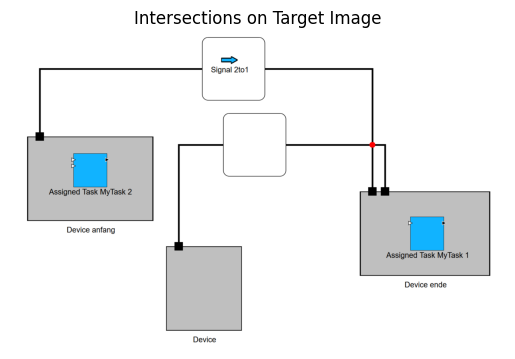

Intersection at: (1290, 404)
Intersection at: (1291, 404)


In [17]:
# finding intersections
intersections_on_target_img = target_img.copy()
cross_0 = cv2.imread('images/cross_kernel_0.png')
cross_1 = cv2.imread('images/cross_kernel_1.png')
cross_2 = cv2.imread('images/cross_kernel_2.png')

res_0 = cv2.matchTemplate(intersections_on_target_img, cross_0, cv2.TM_CCOEFF_NORMED)
res_1 = cv2.matchTemplate(intersections_on_target_img, cross_1, cv2.TM_CCOEFF_NORMED)
res_2 = cv2.matchTemplate(intersections_on_target_img, cross_2, cv2.TM_CCOEFF_NORMED)

# Find the res variable with the best matches
max_val_0 = cv2.minMaxLoc(res_0)[1]
max_val_1 = cv2.minMaxLoc(res_1)[1]
max_val_2 = cv2.minMaxLoc(res_2)[1]

# Determine which res variable has the highest maximum value
max_vals = [max_val_0, max_val_1, max_val_2]
best_res_index = max_vals.index(max(max_vals))

# Select the best res variable
if best_res_index == 0:
    res = res_0
    print("Cross image 0 has been used.")
elif best_res_index == 1:
    res = res_1
    print("Cross image 1 has been used.")
else:
    res = res_2
    print("Cross image 2 has been used.")

# Threshold the result
threshold = 0.9 # 0.92 or lower results in multiple matches per crossing
loc = np.where(res >= threshold)

# Move the detected crosses 6 pixels to the right and 6 pixels down so the intersections match the center of the cross
# (12 by 12 template)
loc = (loc[0] + 6, loc[1] + 6)

# Print the coordinates of the found intersections
for pt in zip(*loc[::-1]):
    cv2.circle(intersections_on_target_img, pt, 10, (0, 0, 255), -1)

# Display the image with intersections
plt.imshow(cv2.cvtColor(intersections_on_target_img, cv2.COLOR_BGR2RGB))
plt.title('Intersections on Target Image')
plt.axis('off')
plt.show()

for pt in zip(*loc[::-1]):
    print(f"Intersection at: ({int(pt[0])}, {int(pt[1])})")

#### removing double intersections

Filtered Intersection at: (1290, 404)


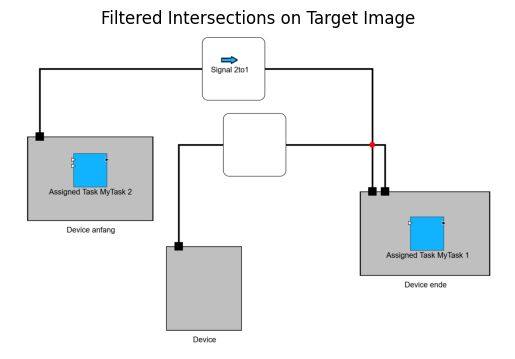

In [18]:
def remove_close_intersections(intersections, proximity=5):
    # Sort intersections by x and then by y to ensure upper left ones come first
    intersections = sorted(intersections, key=lambda pt: (pt[0], pt[1]))
    
    filtered_intersections = []
    while intersections:
        current = intersections.pop(0)
        filtered_intersections.append(current)
        
        # Remove intersections that are within the proximity range
        intersections = [pt for pt in intersections if abs(pt[0] - current[0]) > proximity or abs(pt[1] - current[1]) > proximity]
    
    return filtered_intersections

# Convert loc to a list of tuples
intersections = list(zip(*loc[::-1]))

# Remove close intersections
intersections = remove_close_intersections(intersections, proximity=5)

# Print the filtered intersections
for pt in intersections:
    print(f"Filtered Intersection at: ({int(pt[0])}, {int(pt[1])})")

# Visualize the filtered intersections on the target image
filtered_intersections_img = target_img.copy()
for pt in intersections:
    cv2.circle(filtered_intersections_img, pt, 10, (0, 0, 255), -1)

plt.imshow(cv2.cvtColor(filtered_intersections_img, cv2.COLOR_BGR2RGB))
plt.title('Filtered Intersections on Target Image')
plt.axis('off')
plt.show()

### connecting intersections
At each intersection, the lines corresponding to the four nearest points are connected.

In [19]:
def find_closest_lines(crossing, line_segments_ver_sorted, line_segments_hor_sorted, tolerance=5):
    x, y = crossing
    closest_ver = sorted(line_segments_ver_sorted, key=lambda seg: min(abs(seg[0][0] - x), abs(seg[1][0] - x)) + tolerance)[:2]
    closest_hor = sorted(line_segments_hor_sorted, key=lambda seg: min(abs(seg[0][1] - y), abs(seg[1][1] - y)) + tolerance)[:2]
    return closest_ver, closest_hor

def merge_lines(closest_ver, closest_hor):
    merged_ver = (min(closest_ver[0][0][1], closest_ver[1][0][1]), max(closest_ver[0][1][1], closest_ver[1][1][1]))
    merged_hor = (min(closest_hor[0][0][0], closest_hor[1][0][0]), max(closest_hor[0][1][0], closest_hor[1][1][0]))
    return merged_ver, merged_hor

def connect_lines_at_crossings(crossings, line_segments_ver_sorted, line_segments_hor_sorted, tolerance=5):
    merged_lines = []
    for crossing in crossings:
        closest_ver, closest_hor = find_closest_lines(crossing, line_segments_ver_sorted, line_segments_hor_sorted, tolerance)
        
        if len(closest_ver) < 2 or len(closest_hor) < 2:
            continue  # Skip if there are not enough lines to merge
        
        merged_ver, merged_hor = merge_lines(closest_ver, closest_hor)
        
        for line in closest_ver:
            line_segments_ver_sorted.remove(line)
        for line in closest_hor:
            line_segments_hor_sorted.remove(line)
        
        new_ver_line = ((crossing[0], merged_ver[0]), (crossing[0], merged_ver[1]))
        new_hor_line = ((merged_hor[0], crossing[1]), (merged_hor[1], crossing[1]))
        
        line_segments_ver_sorted.append(new_ver_line)
        line_segments_hor_sorted.append(new_hor_line)
        
        merged_lines.append((new_ver_line, new_hor_line))
    
    return line_segments_ver_sorted, line_segments_hor_sorted, merged_lines

line_segments_ver_sorted, line_segments_hor_sorted, merged_lines = connect_lines_at_crossings(intersections, line_segments_ver_sorted, line_segments_hor_sorted, tolerance=5)

#### visualize the line segments

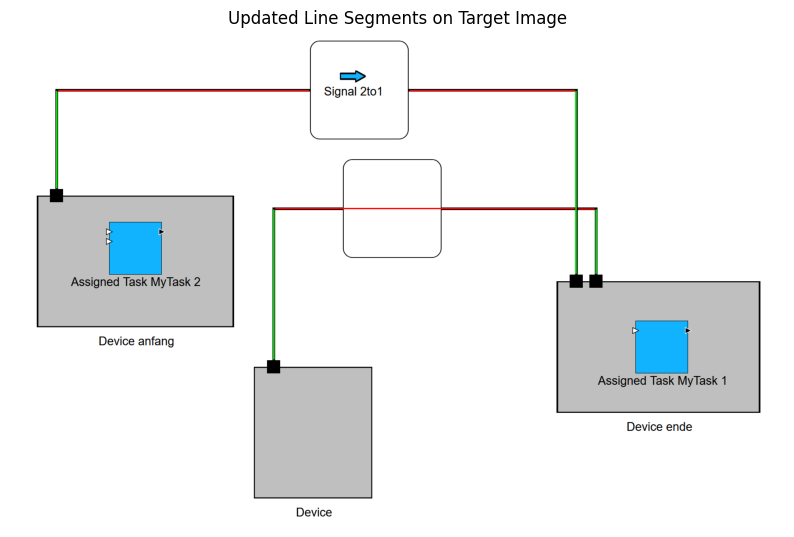

Total number of vertical line segments: 4
Total number of horizontal line segments: 4


In [20]:
# Draw the updated vertical and horizontal line segments on the target image
target_img_with_merged_lines = target_img.copy()
for line in line_segments_ver_sorted:
    cv2.line(target_img_with_merged_lines, line[0], line[1], (0, 255, 0), 2)
for line in line_segments_hor_sorted:
    cv2.line(target_img_with_merged_lines, line[0], line[1], (0, 0, 255), 2)

# Display the image with updated line segments
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_img_with_merged_lines, cv2.COLOR_BGR2RGB))
plt.title('Updated Line Segments on Target Image')
plt.axis('off')
plt.show()
print(f"Total number of vertical line segments: {len(line_segments_ver_sorted)}")
print(f"Total number of horizontal line segments: {len(line_segments_hor_sorted)}")

## convert segment chains to polylines

[[[(106, 137), (106, 357)], [(110, 135), (681, 135)]], [[(601, 407), (601, 747)], [(605, 404), (1286, 404)], [(1296, 405), (1332, 405)], [(1336, 407), (1336, 552)]], [[(1290, 137), (1290, 552)], [(911, 135), (1287, 135)]]]


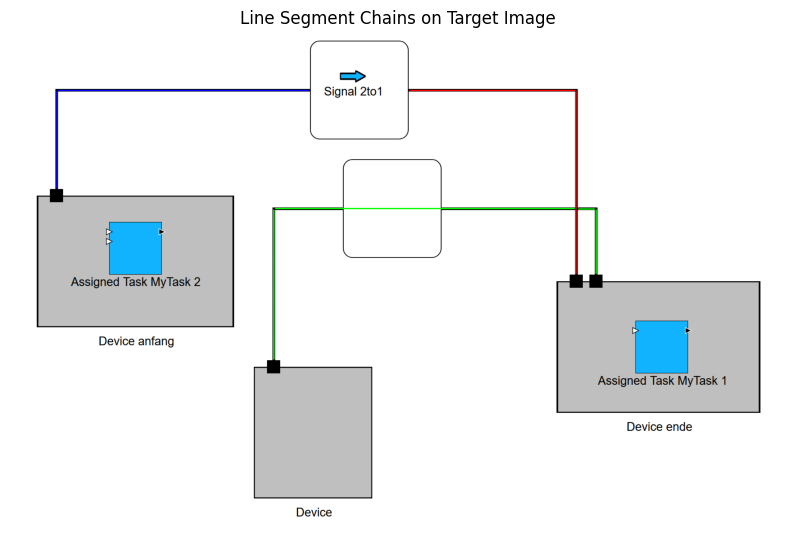

Number of found individual chains: 3


In [21]:
def distance(p1, p2):
    x1, y1, x2, y2 = p1[0], p1[1], p2[0], p2[1] 
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]

# Convert line segments to regular integers
line_segments_ver_sorted = [
    [(int(x1), int(y1)), (int(x2), int(y2))]
    for ((x1, y1), (x2, y2)) in line_segments_ver_sorted
]

line_segments_hor_sorted = [
    [(int(x1), int(y1)), (int(x2), int(y2))]
    for ((x1, y1), (x2, y2)) in line_segments_hor_sorted
]

line_segments = line_segments_ver_sorted + line_segments_hor_sorted

max_distance = 20

line_segment_chains = []
used_segments = []

for i, segment1 in enumerate(line_segments):
    if segment1 in used_segments:
        continue
    chain = [segment1]
    used_segments.append(segment1)
    
    chain_growing = True  # Flag to check if the chain is still growing
    while chain_growing:
        chain_growing = False  # Assume no new segments are added in this iteration
        for j, segment2 in enumerate(line_segments):
            if segment2 in used_segments:
                continue

            # Check if the new segment connects to any of the current chain's segments
            for chain_segment in chain:
                if (distance(chain_segment[0], segment2[0]) <= max_distance or
                    distance(chain_segment[0], segment2[1]) <= max_distance or
                    distance(chain_segment[1], segment2[0]) <= max_distance or
                    distance(chain_segment[1], segment2[1]) <= max_distance):
                    
                    chain.append(segment2)
                    used_segments.append(segment2)
                    chain_growing = True  # Keep growing the chain
                    break  # No need to check other chain segments for this one
            if chain_growing:
                break  # If we've added a segment, restart the outer loop

    line_segment_chains.append(chain)

print(line_segment_chains)

# Draw the chains on the image
target_img_with_chains = target_img.copy()
for i, chain in enumerate(line_segment_chains):
    color = colors[i % len(colors)]
    for segment in chain:
        cv2.line(target_img_with_chains, segment[0], segment[1], color, 2)

# Display the image with chains
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_img_with_chains, cv2.COLOR_BGR2RGB))
plt.title('Line Segment Chains on Target Image')
plt.axis('off')
plt.show()
print(f"Number of found individual chains: {len(line_segment_chains)}")

#### finding endpoints of chains by looking for points with no other points in their proximity

In [22]:
endpoints_of_chains = []
for i, chain in enumerate(line_segment_chains):
    endpoints = []
    for segment in chain:
        for point in segment:
            if all(distance(point, other_point) > max_distance for other_segment in chain for other_point in other_segment if point != other_point):
                endpoints.append(point)
            
    print(f"Chain {i} endpoints: {endpoints}")
    endpoints_of_chains.append(endpoints)

sorted_chains = []
for i, chain in enumerate(line_segment_chains):
    if not endpoints_of_chains[i]:
        sorted_chains.append(chain)
        print(f"Chain {i} has no endpoints, skipping sorting")
        continue
    
    start_point = endpoints_of_chains[i][0]
    sorted_chain = [start_point]
    remaining_segments = chain.copy()
    
    while remaining_segments:
        last_point = sorted_chain[-1]
        next_segment = min(remaining_segments, key=lambda seg: min(distance(last_point, seg[0]), distance(last_point, seg[1])))
        remaining_segments.remove(next_segment)
        
        if distance(last_point, next_segment[0]) < distance(last_point, next_segment[1]):
            if next_segment[0] != last_point:
                sorted_chain.append(next_segment[0])
            sorted_chain.append(next_segment[1])
        else:
            if next_segment[1] != last_point:
                sorted_chain.append(next_segment[1])
            sorted_chain.append(next_segment[0])
    
    sorted_chains.append(sorted_chain)
print(sorted_chains)

Chain 0 endpoints: [(106, 357), (681, 135)]
Chain 1 endpoints: [(601, 747), (1336, 552)]
Chain 2 endpoints: [(1290, 552), (911, 135)]
[[(106, 357), (106, 137), (110, 135), (681, 135)], [(601, 747), (601, 407), (605, 404), (1286, 404), (1296, 405), (1332, 405), (1336, 407), (1336, 552)], [(1290, 552), (1290, 137), (1287, 135), (911, 135)]]


In [23]:
# Iterate through each chain and create OpenCV polylines
opencv_polylines = []
for chain in sorted_chains:
    polyline = []
    for segment in chain:
        polyline.append(segment[0])
        polyline.append(segment[1])
    opencv_polylines.append(np.array(polyline, dtype=np.int32).reshape((-1, 1, 2)))

for i, polyline in enumerate(opencv_polylines):
    formatted_points = ', '.join([f"({point[0][0]}, {point[0][1]})" for point in polyline])
    print(f"Polyline {i}: {formatted_points}")

Polyline 0: (106, 357), (106, 137), (110, 135), (681, 135)
Polyline 1: (601, 747), (601, 407), (605, 404), (1286, 404), (1296, 405), (1332, 405), (1336, 407), (1336, 552)
Polyline 2: (1290, 552), (1290, 137), (1287, 135), (911, 135)


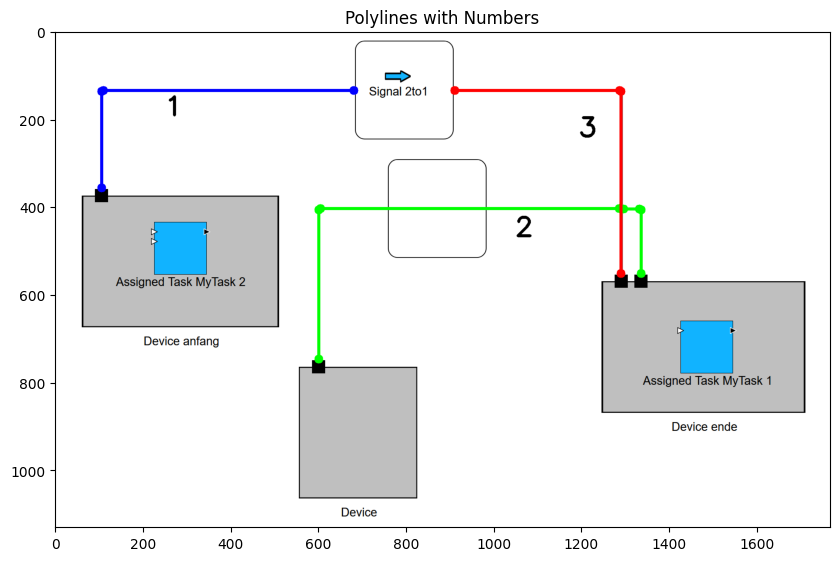

In [24]:
# Filter out None values and convert to integer tuples
filtered_polylines = []
for polyline in opencv_polylines:
    filtered_polyline = [point for point in polyline if point is not None]
    filtered_polylines.append(filtered_polyline)

# Define colors for the polylines
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]

# Draw the polylines
polyline_img = target_img.copy()
for i, polyline in enumerate(opencv_polylines):
    color = colors[i % len(colors)]
    cv2.polylines(polyline_img, [polyline], isClosed=False, color=color, thickness=6)
    for point in polyline:
        cv2.circle(polyline_img, tuple(point.squeeze()), 10, color, -1)

# Draw the lines on the target_img.copy()
target_img_with_polylines = target_img.copy()
for i, polyline in enumerate(opencv_polylines):
    color = colors[i % len(colors)]
    cv2.polylines(target_img_with_polylines, [polyline], isClosed=False, color=color, thickness=6)
    for point in polyline:
        cv2.circle(target_img_with_polylines, tuple(point.squeeze()), 10, color, -1)

# Print the number of each polyline on the image
for i, polyline in enumerate(opencv_polylines):
    # Calculate the center of the polyline for placing the text
    center_x = int(np.mean(polyline[:, 0, 0]))
    center_y = int(np.mean(polyline[:, 0, 1]))
    cv2.putText(target_img_with_polylines, str(i + 1), (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 5)

# Plot the polylines with numbers
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(target_img_with_polylines, cv2.COLOR_BGR2RGB))
plt.title('Polylines with Numbers')
plt.show()